In [1]:
import pandas as pd
import numpy as np
import xgboost
import time
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import gc
import pickle

- Summary: 
Select features by recursively remove least important features, and evaluate the performance of features by cross validation. 
- Conclusion:
Tested on Leaderboard. Features selected by this method give a moderately high score, but not the best score

In [2]:
start_time = time.time()
data_folder = 'data'
sample_frac = 0.1

In [3]:
correlated_cols = pd.read_pickle('data/high_corr_features.pickle')
len(correlated_cols)

21

In [4]:
data_full_features = pd.read_pickle('data/train_full_features.pickle')
data_full_features.drop(correlated_cols, axis=1, inplace=True)
data_full_features = data_full_features.sample(frac=sample_frac, random_state=1).reset_index(drop=True)

# split to X, y
drop_cols = ['order_id', 'user_id', 'product_id', 'reordered']
X = data_full_features.drop(drop_cols, axis=1)
y = data_full_features['reordered']

print(X.shape)
# split on user level
cv_split_base = data_full_features['user_id']

# release memory
gc.collect(); del data_full_features

(847466, 192)


In [5]:
# model
xgb_params = {
    'n_estimators': 1000
    , "objective": "binary:logistic"
    , "eval_metric": ['auc', 'logloss']
    , "eta": 0.1
    , "max_depth": 6
    , "min_child_weight": 10
    , "gamma": 0.70
    , "subsample": 0.76
    , "colsample_bytree": 0.8
    , "alpha": 2e-05
    , "lambda": 10
    , "tree_method": 'hist'
    , "early_stopping_rounds": 30
    , "random_state": 19
    , "predictor": 'cpu_predictor'
}
bst = xgboost.XGBClassifier(**xgb_params)

In [6]:
def refcv(X, y, min_features, step, cv_split_base, val_frac=0.2):
    cv_res = {'cv_train_logloss': [], 'cv_train_auc': [], 'cv_val_logloss': [], 'cv_val_auc': []}
    cv_train_logloss, cv_train_auc, cv_val_logloss, cv_val_auc, num_features_changes, cols_dropped = [], [], [], [], [], []
    num_iter = int(np.ceil((X.shape[1] - min_features)/step))
    # for i in tqdm(range(num_iter)):
    for i in trange(num_iter):
        train_logloss, val_logloss, train_auc, val_auc = [], [], [], []
        num_features_changes.append(X.shape[1])
        for train_idx, test_idx in GroupKFold(n_splits=3).split(X, y, groups=cv_split_base):
            # performance in each fold with i features
            X_train, X_val = X.loc[train_idx], X.loc[test_idx]
            y_train, y_val = y.loc[train_idx], y.loc[test_idx]

            bst.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)
            res = bst.evals_result()
            train_logloss.append(res["validation_0"]["logloss"][-1])
            val_logloss.append(res["validation_1"]["logloss"][-1])
            train_auc.append(res["validation_0"]["auc"][-1])
            val_auc.append(res["validation_1"]["auc"][-1])
        
        # save mean of cv results
        cv_res['cv_train_logloss'].append(np.mean(train_logloss))
        cv_res['cv_train_auc'].append(np.mean(train_auc))
        cv_res['cv_val_logloss'].append(np.mean(val_logloss))
        cv_res['cv_val_auc'].append(np.mean(val_auc))

        # refit full data to get feature importance
        train_size = int(np.round(X.shape[0] * (1-val_frac)))
        val_size = X.shape[0] - train_size
        bst.fit(X.iloc[:train_size, ], y.iloc[:train_size, ], 
                eval_set=[(X.iloc[:train_size, ], y.iloc[:train_size, ]), 
                          (X.iloc[-val_size:, ], y.iloc[-val_size:, ])], verbose=False)
        if X.shape[1] - step < min_features:
            final_step = X.shape[1] - min_features
            min_idx = np.argsort(bst.feature_importances_)[:final_step]
        else:
            min_idx = np.argsort(bst.feature_importances_)[:step]
        to_drop_cols = list(X.columns[min_idx])
        cols_dropped.append(to_drop_cols)
        print('Drop feature(s)', to_drop_cols)
        X = X.drop(to_drop_cols, axis=1)
        print('{} features left'.format(X.shape[1]))
    return cv_res, num_features_changes, cols_dropped

In [7]:
min_features = 130
step = 1
cv_res, num_features_change, cols_dropped  = refcv(X, y, min_features=min_features, step=step, cv_split_base=cv_split_base)

  0%|          | 0/62 [00:00<?, ?it/s]

Drop feature(s) ['p_num_purchases_per_user_min']


  2%|▏         | 1/62 [08:12<8:20:19, 492.12s/it]

191 features left
Drop feature(s) ['up_purchases_pod_midnight']


  3%|▎         | 2/62 [16:37<8:20:06, 500.11s/it]

190 features left
Drop feature(s) ['p_num_purchases_per_user_q20']


  5%|▍         | 3/62 [25:09<8:17:03, 505.49s/it]

189 features left
Drop feature(s) ['p_is_gluten_free']


  6%|▋         | 4/62 [34:04<8:19:59, 517.23s/it]

188 features left
Drop feature(s) ['p_is_asian']


  8%|▊         | 5/62 [42:03<7:58:03, 503.23s/it]

187 features left
Drop feature(s) ['up_organic_substitute_num_purchases_r5']


 10%|▉         | 6/62 [49:46<7:37:02, 489.68s/it]

186 features left
Drop feature(s) ['p_is_organic']


 11%|█▏        | 7/62 [57:58<7:29:27, 490.32s/it]

185 features left
Drop feature(s) ['p_num_products_sim_score_0.9_1.0']


 13%|█▎        | 8/62 [1:04:13<6:48:09, 453.50s/it]

184 features left
Drop feature(s) ['up_norm_purchases_pod_midnight']


 15%|█▍        | 9/62 [1:10:59<6:27:33, 438.74s/it]

183 features left
Drop feature(s) ['p_num_purchases_per_user_median']


 16%|█▌        | 10/62 [1:18:18<6:20:27, 439.00s/it]

182 features left
Drop feature(s) ['up_organic_substitute_num_purchases']


 18%|█▊        | 11/62 [1:25:02<6:03:55, 428.15s/it]

181 features left
Drop feature(s) ['up_purchases_dow_5']


 19%|█▉        | 12/62 [1:31:32<5:47:12, 416.64s/it]

180 features left
Drop feature(s) ['up_purchases_dow_1']


 21%|██        | 13/62 [1:38:10<5:35:32, 410.87s/it]

179 features left
Drop feature(s) ['p_purchase_interval_days_min_woo']


 23%|██▎       | 14/62 [1:45:29<5:35:32, 419.43s/it]

178 features left
Drop feature(s) ['up_word2vec_substitute_num_purchases_r5']


 24%|██▍       | 15/62 [1:52:33<5:29:41, 420.88s/it]

177 features left
Drop feature(s) ['users_purchases_dow_4']


 26%|██▌       | 16/62 [2:01:02<5:43:00, 447.40s/it]

176 features left
Drop feature(s) ['up_purchases_dow_2']


 27%|██▋       | 17/62 [2:10:15<5:59:21, 479.15s/it]

175 features left
Drop feature(s) ['users_asian_food_ratio']


 29%|██▉       | 18/62 [2:18:02<5:48:44, 475.56s/it]

174 features left
Drop feature(s) ['up_purchases_dow_4']


 31%|███       | 19/62 [2:26:15<5:44:31, 480.74s/it]

173 features left
Drop feature(s) ['up_purchases_pod_night']


 32%|███▏      | 20/62 [2:33:46<5:30:06, 471.59s/it]

172 features left
Drop feature(s) ['up_norm_purchases_dow_1']


 34%|███▍      | 21/62 [2:39:55<5:01:18, 440.94s/it]

171 features left
Drop feature(s) ['users_norm_purchases_dow_6']


 35%|███▌      | 22/62 [2:45:53<4:37:25, 416.14s/it]

170 features left
Drop feature(s) ['up_purchases_dow_3']


 37%|███▋      | 23/62 [2:52:10<4:22:52, 404.43s/it]

169 features left
Drop feature(s) ['up_purchases_pod_morning']


 39%|███▊      | 24/62 [2:58:40<4:13:19, 399.99s/it]

168 features left
Drop feature(s) ['users_purchases_dow_5']


 40%|████      | 25/62 [3:05:13<4:05:18, 397.79s/it]

167 features left
Drop feature(s) ['p_embedding_23']


 42%|████▏     | 26/62 [3:12:49<4:09:16, 415.46s/it]

166 features left
Drop feature(s) ['users_asian_food_ratio_r5']


 44%|████▎     | 27/62 [3:19:41<4:01:38, 414.24s/it]

165 features left
Drop feature(s) ['users_norm_purchases_pod_night']


 45%|████▌     | 28/62 [3:26:45<3:56:25, 417.22s/it]

164 features left
Drop feature(s) ['up_norm_purchases_pod_morning']


 47%|████▋     | 29/62 [3:33:48<3:50:22, 418.85s/it]

163 features left
Drop feature(s) ['users_norm_purchases_dow_5']


 48%|████▊     | 30/62 [3:40:49<3:43:44, 419.52s/it]

162 features left
Drop feature(s) ['users_norm_purchases_dow_0']


 50%|█████     | 31/62 [3:47:58<3:38:19, 422.56s/it]

161 features left
Drop feature(s) ['up_norm_purchases_dow_6']


 52%|█████▏    | 32/62 [3:55:01<3:31:15, 422.51s/it]

160 features left
Drop feature(s) ['up_norm_purchases_dow_4']


 53%|█████▎    | 33/62 [4:01:36<3:20:13, 414.27s/it]

159 features left
Drop feature(s) ['up_purchases_pod_noon']


 55%|█████▍    | 34/62 [4:08:50<3:16:07, 420.28s/it]

158 features left
Drop feature(s) ['users_norm_purchases_pod_morning']


 56%|█████▋    | 35/62 [4:14:51<3:01:05, 402.41s/it]

157 features left
Drop feature(s) ['p_num_products_sim_score_0.8_0.9']


 58%|█████▊    | 36/62 [4:21:13<2:51:45, 396.38s/it]

156 features left
Drop feature(s) ['users_norm_purchases_dow_2']


 60%|█████▉    | 37/62 [4:27:29<2:42:37, 390.29s/it]

155 features left
Drop feature(s) ['p_embedding_38']


 61%|██████▏   | 38/62 [4:33:51<2:35:08, 387.84s/it]

154 features left
Drop feature(s) ['p_embedding_24']


 63%|██████▎   | 39/62 [4:42:42<2:45:02, 430.55s/it]

153 features left
Drop feature(s) ['p_num_products_sim_score_0.7_0.8']


 65%|██████▍   | 40/62 [4:52:44<2:56:45, 482.07s/it]

152 features left
Drop feature(s) ['user_product_total']


 66%|██████▌   | 41/62 [5:00:17<2:45:39, 473.33s/it]

151 features left
Drop feature(s) ['up_norm_purchases_dow_3']


 68%|██████▊   | 42/62 [5:06:44<2:29:10, 447.52s/it]

150 features left
Drop feature(s) ['up_norm_purchases_dow_2']


 69%|██████▉   | 43/62 [5:13:07<2:15:33, 428.08s/it]

149 features left
Drop feature(s) ['users_purchases_dow_0']


 71%|███████   | 44/62 [5:19:12<2:02:45, 409.21s/it]

148 features left
Drop feature(s) ['users_purchases_dow_2']


 73%|███████▎  | 45/62 [5:25:55<1:55:23, 407.27s/it]

147 features left
Drop feature(s) ['users_purchases_pod_night']


 74%|███████▍  | 46/62 [5:32:25<1:47:12, 402.04s/it]

146 features left
Drop feature(s) ['users_gluten_free_ratio_r5']


 76%|███████▌  | 47/62 [5:38:49<1:39:12, 396.86s/it]

145 features left
Drop feature(s) ['users_norm_purchases_dow_1']


 77%|███████▋  | 48/62 [5:45:53<1:34:30, 405.03s/it]

144 features left
Drop feature(s) ['p_embedding_7']


 79%|███████▉  | 49/62 [5:52:36<1:27:36, 404.35s/it]

143 features left
Drop feature(s) ['users_purchases_pod_midnight']


 81%|████████  | 50/62 [5:58:58<1:19:32, 397.73s/it]

142 features left
Drop feature(s) ['up_norm_purchases_dow_0']


 82%|████████▏ | 51/62 [6:05:49<1:13:38, 401.64s/it]

141 features left
Drop feature(s) ['p_embedding_30']


 84%|████████▍ | 52/62 [6:12:31<1:06:55, 401.56s/it]

140 features left
Drop feature(s) ['p_embedding_34']


 85%|████████▌ | 53/62 [6:19:46<1:01:45, 411.75s/it]

139 features left
Drop feature(s) ['p_embedding_32']


 87%|████████▋ | 54/62 [6:26:23<54:17, 407.14s/it]  

138 features left
Drop feature(s) ['users_norm_purchases_pod_noon']


 89%|████████▊ | 55/62 [6:33:20<47:51, 410.24s/it]

137 features left
Drop feature(s) ['users_norm_purchases_dow_4']


 90%|█████████ | 56/62 [6:40:03<40:48, 408.14s/it]

136 features left
Drop feature(s) ['up_norm_purchases_pod_noon']


 92%|█████████▏| 57/62 [6:45:55<32:36, 391.21s/it]

135 features left
Drop feature(s) ['p_embedding_10']


 94%|█████████▎| 58/62 [6:51:45<25:15, 378.76s/it]

134 features left
Drop feature(s) ['p_num_products_sim_score_0.6_0.7']


 95%|█████████▌| 59/62 [6:57:29<18:25, 368.35s/it]

133 features left
Drop feature(s) ['up_word2vec_substitute_num_purchases']


 97%|█████████▋| 60/62 [7:03:14<12:02, 361.48s/it]

132 features left
Drop feature(s) ['users_norm_purchases_dow_3']


 98%|█████████▊| 61/62 [7:09:00<05:56, 356.70s/it]

131 features left
Drop feature(s) ['users_norm_purchases_pod_midnight']


100%|██████████| 62/62 [7:15:00<00:00, 420.98s/it]

130 features left


In [8]:
cols_dropped

[['p_num_purchases_per_user_min'],
 ['up_purchases_pod_midnight'],
 ['p_num_purchases_per_user_q20'],
 ['p_is_gluten_free'],
 ['p_is_asian'],
 ['up_organic_substitute_num_purchases_r5'],
 ['p_is_organic'],
 ['p_num_products_sim_score_0.9_1.0'],
 ['up_norm_purchases_pod_midnight'],
 ['p_num_purchases_per_user_median'],
 ['up_organic_substitute_num_purchases'],
 ['up_purchases_dow_5'],
 ['up_purchases_dow_1'],
 ['p_purchase_interval_days_min_woo'],
 ['up_word2vec_substitute_num_purchases_r5'],
 ['users_purchases_dow_4'],
 ['up_purchases_dow_2'],
 ['users_asian_food_ratio'],
 ['up_purchases_dow_4'],
 ['up_purchases_pod_night'],
 ['up_norm_purchases_dow_1'],
 ['users_norm_purchases_dow_6'],
 ['up_purchases_dow_3'],
 ['up_purchases_pod_morning'],
 ['users_purchases_dow_5'],
 ['p_embedding_23'],
 ['users_asian_food_ratio_r5'],
 ['users_norm_purchases_pod_night'],
 ['up_norm_purchases_pod_morning'],
 ['users_norm_purchases_dow_5'],
 ['users_norm_purchases_dow_0'],
 ['up_norm_purchases_dow_6']

In [9]:
cols_dropped_flat = [item for sublist in cols_dropped for item in sublist]
cols_dropped_flat

['p_num_purchases_per_user_min',
 'up_purchases_pod_midnight',
 'p_num_purchases_per_user_q20',
 'p_is_gluten_free',
 'p_is_asian',
 'up_organic_substitute_num_purchases_r5',
 'p_is_organic',
 'p_num_products_sim_score_0.9_1.0',
 'up_norm_purchases_pod_midnight',
 'p_num_purchases_per_user_median',
 'up_organic_substitute_num_purchases',
 'up_purchases_dow_5',
 'up_purchases_dow_1',
 'p_purchase_interval_days_min_woo',
 'up_word2vec_substitute_num_purchases_r5',
 'users_purchases_dow_4',
 'up_purchases_dow_2',
 'users_asian_food_ratio',
 'up_purchases_dow_4',
 'up_purchases_pod_night',
 'up_norm_purchases_dow_1',
 'users_norm_purchases_dow_6',
 'up_purchases_dow_3',
 'up_purchases_pod_morning',
 'users_purchases_dow_5',
 'p_embedding_23',
 'users_asian_food_ratio_r5',
 'users_norm_purchases_pod_night',
 'up_norm_purchases_pod_morning',
 'users_norm_purchases_dow_5',
 'users_norm_purchases_dow_0',
 'up_norm_purchases_dow_6',
 'up_norm_purchases_dow_4',
 'up_purchases_pod_noon',
 'users_

In [23]:
# fig, axes = plt.subplots(2, 1)
# axes[0].plot(num_features_change, cv_res['cv_train_logloss'], label='train_logloss')
# axes[0].plot(num_features_change, cv_res['cv_val_logloss'], label='val_logloss')
# axes[0].legend()

# axes[1].plot(num_features_change, cv_res['cv_train_auc'], label='train_auc')
# axes[1].plot(num_features_change, cv_res['cv_val_auc'], label='val_auc')
# axes[1].legend()


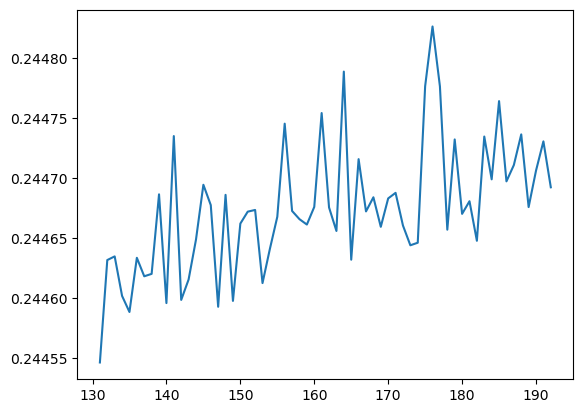

In [13]:
plt.plot(num_features_change, cv_res['cv_val_logloss'], label='val_logloss')

In [20]:
np.min(cv_res['cv_val_logloss'])

0.24454609712677478

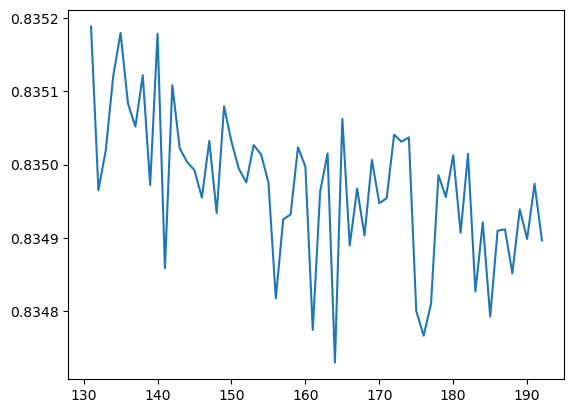

In [14]:
plt.plot(num_features_change, cv_res['cv_val_auc'], label='val_auc')

In [22]:
np.max(cv_res['cv_val_auc'])

0.8351883890046977

In [21]:
with open('data/refcv_custom_dropped_cols.pickle', 'wb+') as f:
    pickle.dump(cols_dropped_flat, f)

In [29]:
cv_res_df = pd.DataFrame(cv_res)
cv_res_df['num_features'] = num_features_change
cv_res_df.shape

(62, 5)

In [36]:
cv_res_df.to_pickle('data/cv_res_df_from_192_to_130.pickle')

In [12]:
end_time = time.time()
time_spent = (end_time - start_time) / 60
print('spent {:.2f} mins'.format(time_spent))

spent 436.03 mins
